In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import tensorflow as tf
import pathlib
import PIL
import time
import zipfile
import random
from tensorflow.keras.layers import *

In [2]:
MAIN_PATH = r"C:\Users\ŞeymaÇakmak\Desktop\BİL 468\Project\Project Code\Dataset\crop_dataset\crop_dataset"
TEST_PATH = r"C:\Users\ŞeymaÇakmak\Desktop\BİL 468\Project\Project Code\Dataset\test_data"
CLASSES = os.listdir(MAIN_PATH)
NUM_CLASSES = len(CLASSES)
NUM_TEST_IMAGES = len(os.listdir(os.path.join(TEST_PATH,"test_data")))
HEIGHT,WIDTH = 32,32
BATCH_SIZE = 32
SPLIT = 0.2

In [3]:
print(NUM_TEST_IMAGES)

1170


In [4]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    validation_split=SPLIT)
'''
    width_shift_range=0.2,
    height_shift_range=0.2,
    '''
train_ds = train_datagen.flow_from_directory(
    MAIN_PATH,
    target_size = (HEIGHT,WIDTH),
    batch_size = BATCH_SIZE,
    subset = "training",
    class_mode = "categorical",
    shuffle = True
)

val_ds = train_datagen.flow_from_directory(
    MAIN_PATH,
    target_size = (HEIGHT,WIDTH),
    batch_size = BATCH_SIZE,
    subset = "validation",
    class_mode = "categorical",
    shuffle = True
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)
test_ds = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size = (HEIGHT,WIDTH),
    shuffle = False
)





Found 2016 images belonging to 7 classes.
Found 504 images belonging to 7 classes.
Found 1170 images belonging to 1 classes.


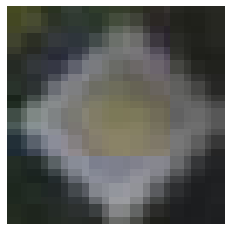

In [5]:
print(test_ds)
import matplotlib.pyplot as plt

# Test veri kümesinden bir örnek alın
sample_image, _ = next(test_ds)

# İlk görüntüyü görselleştirme
plt.imshow(sample_image[0])
plt.axis('off')  # Eksenleri kapatma
plt.show()


In [6]:
# Özelliklerin ve etiketlerin alınması
train_features, train_labels = next(train_ds)
val_features, val_labels = next(val_ds)

Found 2016 images belonging to 7 classes.
Found 504 images belonging to 7 classes.
Eğitim doğruluğu: 1.0
Doğrulama doğruluğu: 0.6875


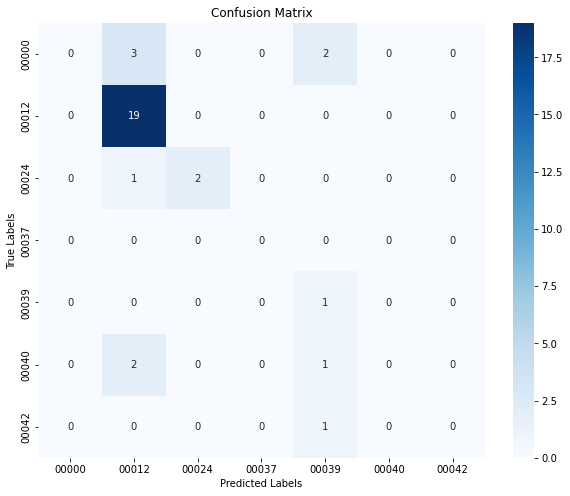

In [7]:
import os
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

def load_dataset(dataset_path):
    classes = os.listdir(dataset_path)
    num_classes = len(classes)
    return classes, num_classes

def preprocess_images(images):
    hog_features = []
    for image in images:
        # Resmi 40x40 piksel boyutuna normalize etme
        resized_image = cv2.resize(image, (40, 40))
        
        # Resmi gri tonlamaya dönüştürme
        gray_image = cv2.cvtColor(resized_image, cv2.COLOR_RGB2GRAY)
        
        # HOG özelliklerini hesaplama
        hog_feature = hog(gray_image, orientations=9, pixels_per_cell=(5, 5),
                          cells_per_block=(2, 2), block_norm='L2-Hys', transform_sqrt=True)
        
        hog_features.append(hog_feature)
    
    return np.array(hog_features)

def train_svm(train_features, train_labels):
    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_features)
    svm_model = SVC(C=1.0, kernel='linear', gamma='scale')
    svm_model.fit(train_features_scaled, train_labels)
    return svm_model, scaler

def evaluate_svm(model, scaler, features, labels):
    features_scaled = scaler.transform(features)
    predictions = model.predict(features_scaled)
    accuracy = accuracy_score(labels, predictions)
    return accuracy, predictions

def plot_confusion_matrix(true_labels, predicted_labels, classes):
    cm = tf.math.confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Ana dosya yolu ve sınıf sayısını tanımlama
MAIN_PATH = r"C:\Users\ŞeymaÇakmak\Desktop\BİL 468\Project\Project Code\Dataset\crop_dataset\crop_dataset"
CLASSES, NUM_CLASSES = load_dataset(MAIN_PATH)

# Veri yükleyici oluşturma
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    validation_split=0.2
)

train_ds = train_datagen.flow_from_directory(
    MAIN_PATH,
    target_size=(32, 32),
    batch_size=32,
    subset="training",
    class_mode="categorical",
    shuffle=True
)

val_ds = train_datagen.flow_from_directory(
    MAIN_PATH,
    target_size=(32, 32),
    batch_size=32,
    subset="validation",
    class_mode="categorical",
    shuffle=True
)

# Eğitim verilerini ve etiketlerini alınması
train_features, train_labels = next(train_ds)
val_features, val_labels = next(val_ds)

# Verilerin ön işlenmesi
train_features_hog = preprocess_images(train_features)
val_features_hog = preprocess_images(val_features)

# Modeli eğitme
svm_model, scaler = train_svm(train_features_hog, np.argmax(train_labels, axis=1))

# Modelin değerlendirilmesi
train_accuracy, train_predictions = evaluate_svm(svm_model, scaler, train_features_hog, np.argmax(train_labels, axis=1))
val_accuracy, val_predictions = evaluate_svm(svm_model, scaler, val_features_hog, np.argmax(val_labels, axis=1))

# Sonuçları yazdırma
print("Eğitim doğruluğu:", train_accuracy)
print("Doğrulama doğruluğu:", val_accuracy)

# Doğruluk değerlerini kullanarak confusion matrix oluşturma ve görselleştirme
plot_confusion_matrix(np.argmax(val_labels, axis=1), val_predictions, CLASSES)


In [8]:
from sklearn.ensemble import RandomForestClassifier

def train_random_forest(train_features, train_labels):
    random_forest_model = RandomForestClassifier(n_estimators=1000, random_state=42)
    random_forest_model.fit(train_features, train_labels)
    return random_forest_model

# Modeli eğitme
random_forest_model = train_random_forest(train_features_hog, np.argmax(train_labels, axis=1))

# Modelin değerlendirilmesi
train_accuracy_rf = random_forest_model.score(train_features_hog, np.argmax(train_labels, axis=1))
val_accuracy_rf = random_forest_model.score(val_features_hog, np.argmax(val_labels, axis=1))

# Sonuçları yazdırma
print("Eğitim doğruluğu (Random Forest):", train_accuracy_rf)
print("Doğrulama doğruluğu (Random Forest):", val_accuracy_rf)


Eğitim doğruluğu (Random Forest): 1.0
Doğrulama doğruluğu (Random Forest): 0.59375


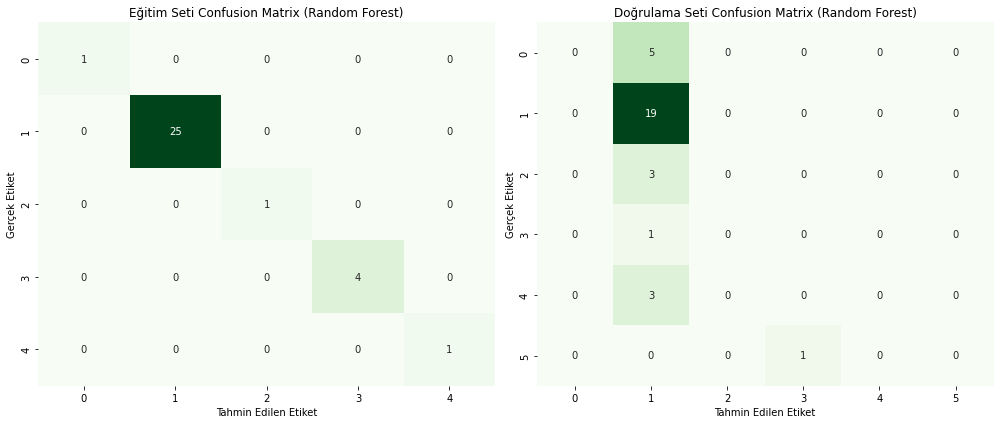

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Eğitim ve doğrulama verilerini kullanarak tahminler yapma
train_predictions_rf = random_forest_model.predict(train_features_hog)
val_predictions_rf = random_forest_model.predict(val_features_hog)

# Confusion matrix hesaplama
train_cm_rf = confusion_matrix(np.argmax(train_labels, axis=1), train_predictions_rf)
val_cm_rf = confusion_matrix(np.argmax(val_labels, axis=1), val_predictions_rf)

# Confusion matrixleri görselleştirme
plt.figure(figsize=(14, 6))

# Eğitim seti confusion matrixi
plt.subplot(1, 2, 1)
sns.heatmap(train_cm_rf, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Eğitim Seti Confusion Matrix (Random Forest)')
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')

# Doğrulama seti confusion matrixi
plt.subplot(1, 2, 2)
sns.heatmap(val_cm_rf, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Doğrulama Seti Confusion Matrix (Random Forest)')
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')

plt.tight_layout()
plt.show()


In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV  


# KNN modeli oluşturma
knn_model = KNeighborsClassifier()

# Test edilecek hiperparametreler ve değer aralıklarını belirleme
param_grid_knn = {
    'n_neighbors': [3, 5, 7],        # Komşu sayısı
    'weights': ['uniform', 'distance'],  # Komşuların ağırlıkları
    'metric': ['euclidean', 'manhattan']  # Mesafe metriği
}

# GridSearchCV kullanarak en iyi hiperparametreleri bulma
grid_search_knn = GridSearchCV(estimator=knn_model, param_grid=param_grid_knn, cv=3)
grid_search_knn.fit(train_features_hog, np.argmax(train_labels, axis=1))

# En iyi hiperparametreleri ve skorları yazdırma
print("En iyi parametreler (KNN):", grid_search_knn.best_params_)
print("En iyi skor (KNN):", grid_search_knn.best_score_)

# En iyi parametrelerle modeli tekrar eğitme
best_knn_model = KNeighborsClassifier(**grid_search_knn.best_params_)
best_knn_model.fit(train_features_hog, np.argmax(train_labels, axis=1))

# Modelin değerlendirilmesi
train_accuracy_knn = best_knn_model.score(train_features_hog, np.argmax(train_labels, axis=1))
val_accuracy_knn = best_knn_model.score(val_features_hog, np.argmax(val_labels, axis=1))

# Sonuçları yazdırma
print("Eğitim doğruluğu (KNN):", train_accuracy_knn)
print("Doğrulama doğruluğu (KNN):", val_accuracy_knn)


En iyi parametreler (KNN): {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
En iyi skor (KNN): 0.8757575757575758
Eğitim doğruluğu (KNN): 1.0
Doğrulama doğruluğu (KNN): 0.65625


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


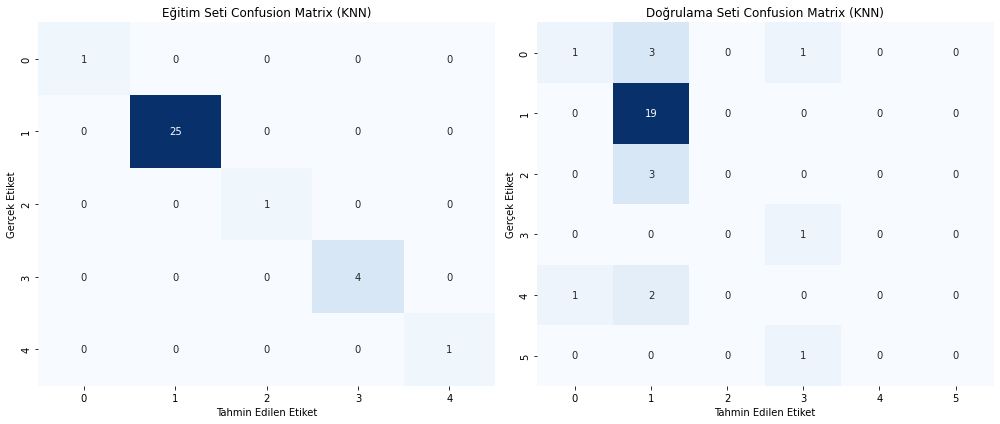

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Eğitim ve doğrulama verilerini kullanarak tahminler yapma
train_predictions_knn = best_knn_model.predict(train_features_hog)
val_predictions_knn = best_knn_model.predict(val_features_hog)

# Confusion matrix hesaplama
train_cm_knn = confusion_matrix(np.argmax(train_labels, axis=1), train_predictions_knn)
val_cm_knn = confusion_matrix(np.argmax(val_labels, axis=1), val_predictions_knn)

# Confusion matrixleri görselleştirme
plt.figure(figsize=(14, 6))

# Eğitim seti confusion matrixi
plt.subplot(1, 2, 1)
sns.heatmap(train_cm_knn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Eğitim Seti Confusion Matrix (KNN)')
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')

# Doğrulama seti confusion matrixi
plt.subplot(1, 2, 2)
sns.heatmap(val_cm_knn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Doğrulama Seti Confusion Matrix (KNN)')
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')

plt.tight_layout()
plt.show()


In [21]:
import os
import cv2
import numpy as np

def load_test_data_and_labels(data_path, labels_path):
    test_features = []
    test_labels = []

    # Etiket dosyasını okuma
    with open(labels_path, 'r') as file:
        next(file)  # Başlık satırını atla
        for line in file:
            # Satırı virgülle ayırarak parçala ve etiketi al
            image_filename, label = line.strip().split(',')
            label = int(label)

            # Görüntü dosyasının tam yolunu oluştur
            image_path = os.path.join(data_path, image_filename)

            # Görüntüyü oku
            image = cv2.imread(image_path)

            # Görüntü yoksa veya boyutları uygun değilse atla
            if image is None or image.shape[0] != 32 or image.shape[1] != 32:
                continue

            # Görüntüyü normalize et ve özellikler listesine ekle
            image = image / 255.0
            test_features.append(image)
            test_labels.append(label)

    # Liste verilerini NumPy dizisine dönüştür
    test_features = np.array(test_features)
    test_labels = np.array(test_labels)

    return test_features, test_labels


In [22]:
# Test verilerini ve etiketlerini yükleme
test_data_path = r'C:\Users\ŞeymaÇakmak\Desktop\BİL 468\Project\Project Code\Dataset\test_data\test_data'
test_labels_path = r'C:\Users\ŞeymaÇakmak\Desktop\BİL 468\Project\Project Code\Dataset\test_labels.csv'
test_features, test_labels = load_test_data_and_labels(test_data_path, test_labels_path)
print(test_features_hog)
# Test verilerini HOG özelliklerine dönüştürme
test_features_hog = preprocess_images(test_features)

[]


In [19]:
print(test_features_hog)

[]


In [17]:
def test_random_forest(model, test_features, test_labels):
    # Test verilerinin doğruluğunu hesaplama
    test_accuracy = model.score(test_features, test_labels)
    print("Test doğruluğu (Random Forest):", test_accuracy)
    return test_accuracy


In [18]:
test_accuracy_rf = test_random_forest(random_forest_model, test_features_hog, np.argmax(test_labels))


ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [15]:
# Test verilerini ve etiketlerini yükleme
test_data_path = r'C:\Users\ŞeymaÇakmak\Desktop\BİL 468\Project\Project Code\Dataset\test_data\test_data'
test_labels_path = r'C:\Users\ŞeymaÇakmak\Desktop\BİL 468\Project\Project Code\Dataset\test_labels.csv'
test_features, test_labels = load_test_data_and_labels(test_data_path, test_labels_path)

# Test verilerini HOG özelliklerine dönüştürme
test_features_hog = preprocess_images(test_features)

# Modelin doğruluğunu değerlendirme
test_accuracy_knn = best_knn_model.score(test_features_hog, test_labels)
print("Test Doğruluğu (KNN):", test_accuracy_knn)

# Confusion matrix oluşturma
from sklearn.metrics import confusion_matrix
predictions = best_knn_model.predict(test_features_hog)
conf_matrix = confusion_matrix(test_labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)


KeyboardInterrupt: 